In [6]:
%load_ext autoreload
%autoreload 2

import cv2
import torch
from kornia_moons.feature import *
import pycolmap
import os
import h5py
import kornia as K
import kornia.feature as KF
from fastprogress import progress_bar
import matplotlib.pyplot as plt

def load_torch_image(fname, device=torch.device('cpu')):
    img = K.image_to_tensor(cv2.imread(fname), False).float() /255.
    img = K.color.bgr_to_rgb(img.to(device))
    return img

device = torch.device('cpu')



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Download example data

In [93]:

!wget http://cmp.felk.cvut.cz/~mishkdmy/wooden_lady_subset.zip

--2023-03-13 14:17:32--  http://cmp.felk.cvut.cz/~mishkdmy/wooden_lady_subset.zip
Resolving cmp.felk.cvut.cz (cmp.felk.cvut.cz)... 147.32.84.2
Connecting to cmp.felk.cvut.cz (cmp.felk.cvut.cz)|147.32.84.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34534975 (33M) [application/zip]
Saving to: ‘wooden_lady_subset.zip.1’

wooden_lady_subset. 100%[===================>]  32,93M  6,53MB/s    in 5,1s    

2023-03-13 14:17:37 (6,50 MB/s) - ‘wooden_lady_subset.zip.1’ saved [34534975/34534975]



In [4]:
%%capture
!unzip -o wooden_lady_subset.zip

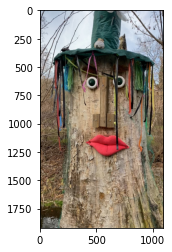

In [11]:
dirname = 'wooden_lady_subset'
img_fnames = [os.path.join(dirname, x) for x in os.listdir(dirname) if '.jpg' in x]
plt.imshow(cv2.cvtColor(cv2.imread(img_fnames[0]), cv2.COLOR_BGR2RGB))

In [17]:
def detect_features(img_fnames,
                    num_feats = 2048,
                    upright = True,
                    device=torch.device('cpu'),
                    feature_dir = '.featureout', resize_to = (800, 600)):
    feature = KF.KeyNetAffNetHardNet(num_feats, upright, device=device).eval().to(device)
    if not os.path.isdir(feature_dir):
        os.makedirs(feature_dir)
    with h5py.File(f'{feature_dir}/lafs.h5', mode='w') as f_laf, \
         h5py.File(f'{feature_dir}/keypoints.h5', mode='w') as f_kp, \
         h5py.File(f'{feature_dir}/descriptors.h5', mode='w') as f_desc:
        for img_path in progress_bar(img_fnames):
            img_fname = img_path.split('/')[-1]
            key = img_fname
            with torch.inference_mode():
                timg = K.color.rgb_to_grayscale(load_torch_image(img_path, device=device))
                H, W = timg.shape[2:]
                if H < W:
                    resize_to = resize_to[1], resize_to[0]
                timg_resized = K.geometry.resize(timg, resize_to, antialias=True)
                h, w = timg_resized.shape[2:]
                lafs, resps, descs =  feature(timg_resized)
                lafs[:,:,0,:] *= float(W) / float(w)
                lafs[:,:,1,:] *= float(H) / float(h)
                desc_dim = descs.shape[-1]
                kpts = KF.get_laf_center(lafs).reshape(-1, 2).detach().cpu().numpy()
                descs = descs.reshape(-1, desc_dim).detach().cpu().numpy()
                f_laf[key] = lafs.detach().cpu().numpy()
                f_kp[key] = kpts
                f_desc[key] = descs
    return


## Detect KeyNetAffNet features

In [18]:
detect_features(img_fnames, 2048, device=device, resize_to=(800, 600))

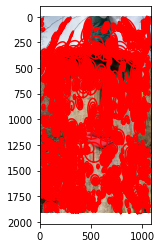

In [29]:
feature_dir = '.featureout'
with h5py.File(f'{feature_dir}/lafs.h5', mode='r') as f_laf:
    img1 = load_torch_image(img_fnames[0])
    key = img_fnames[0].split('/')[-1]
    lafs = torch.from_numpy(f_laf[key][...])
    visualize_LAF(img1, lafs)


## Matching

In [30]:
def get_unique_idxs(A):
    # https://stackoverflow.com/questions/72001505/how-to-get-unique-elements-and-their-firstly-appeared-indices-of-a-pytorch-tenso
    unique, idx, counts = torch.unique(A, dim=0, sorted=True, return_inverse=True, return_counts=True)
    _, ind_sorted = torch.sort(idx, stable=True)
    cum_sum = counts.cumsum(0)
    cum_sum = torch.cat((torch.tensor([0],device=cum_sum.device), cum_sum[:-1]))
    first_indicies = ind_sorted[cum_sum]
    return first_indicies

def match_features(img_fnames,
                   index_pairs,
                   feature_dir = '.featureout',
                   device=torch.device('cpu'),
                   min_matches=15, force_mutual = True):
    with h5py.File(f'{feature_dir}/lafs.h5', mode='r') as f_laf, \
         h5py.File(f'{feature_dir}/descriptors.h5', mode='r') as f_desc, \
        h5py.File(f'{feature_dir}/matches.h5', mode='w') as f_match:
        for pair_idx in progress_bar(index_pairs):
                    idx1, idx2 = pair_idx
                    fname1, fname2 = img_fnames[idx1], img_fnames[idx2]
                    key1, key2 = fname1.split('/')[-1], fname2.split('/')[-1]
                    lafs1 = torch.from_numpy(f_laf[key1][...]).to(device)
                    lafs2 = torch.from_numpy(f_laf[key2][...]).to(device)
                    desc1 = torch.from_numpy(f_desc[key1][...]).to(device)
                    desc2 = torch.from_numpy(f_desc[key2][...]).to(device)
                    img1, img2 = cv2.imread(fname1), cv2.imread(fname2)
                    hw1, hw2 = img1.shape[:2], img2.shape[:2]
                    dists, idxs = KF.match_adalam(desc1, desc2,
                                                  lafs1, lafs2, # Adalam takes into account also geometric information
                                                  hw1=hw1, hw2=hw2) # Adalam also benefits from knowing image size
                    if len(idxs)  == 0:
                        continue
                    # Force mutual nearest neighbors
                    if force_mutual:
                        first_indicies = get_unique_idxs(idxs[:,1])
                        idxs = idxs[first_indicies]
                        dists = dists[first_indicies]
                    n_matches = len(idxs)
                    if False:
                        print (f'{key1}-{key2}: {n_matches} matches')
                    group  = f_match.require_group(key1)
                    if n_matches >= min_matches:
                         group.create_dataset(key2, data=idxs.detach().cpu().numpy().reshape(-1, 2))
    return


In [31]:
# matching all to all
index_pairs = []
for i in range(len(img_fnames)):
    for j in range(i+1, len(img_fnames)):
        index_pairs.append((i,j))


In [32]:
match_features(img_fnames, index_pairs, device=torch.device('cpu'))

## Import into colmap and run reconstruction

In [34]:
from h5_to_db import add_keypoints, add_matches, COLMAPDatabase

def import_into_colmap(img_dir,
                       feature_dir ='.featureout',
                       database_path = 'colmap.db',
                       img_ext='.jpg'):
    db = COLMAPDatabase.connect(database_path)
    db.create_tables()
    single_camera = False
    fname_to_id = add_keypoints(db, feature_dir, img_dir, img_ext, 'simple-radial', single_camera)
    add_matches(
        db,
        feature_dir,
        fname_to_id,
    )

    db.commit()
    return

database_path = 'colmap.db'
!rm {database_path}
import_into_colmap(dirname, database_path=database_path)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 1246.02it/s]
236it [00:00, 4626.47it/s]                                                                                                                          


In [35]:
output_path = 'colmap_rec'


In [36]:

def run_reconstruction(image_dir, output_path = 'colmap_rec', database_path = 'colmap.db'):
    pycolmap.match_exhaustive(database_path)
    maps = pycolmap.incremental_mapping(database_path, dirname, output_path)
    if not os.path.isdir(output_path):
        os.makedirs(output_path)
    maps[0].write(output_path)
    return maps

In [37]:
maps = run_reconstruction(dirname, output_path, database_path)


Exhaustive feature matching

Matching block [1/1, 1/1] in 1.118s
Elapsed time: 0.019 [minutes]

Loading database

Loading cameras... 23 in 0.000s
Loading matches... 236 in 0.000s
Loading images... 23 in 0.001s (connected 23)
Building correspondence graph... in 0.004s (ignored 0)

Elapsed time: 0.000 [minutes]


Finding good initial image pair


Initializing with image pair #13 and #21


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  6.194382e+02    0.00e+00    1.00e+04   0.00e+00   0.00e+00  1.00e+04        0    3.24e-04    2.79e-03
   1  5.551236e+02    6.43e+01    1.00e+04   4.59e+01   9.99e-01  3.00e+04        1    1.27e-03    4.22e-03
   2  5.063386e+02    4.88e+01    6.15e+04   7.81e+01   9.15e-01  7.00e+04        1    5.93e-04    4.81e-03
   3  5.347684e+02   -2.84e+01    6.15e+04   1.01e+02  -4.69e-01  3.50e+04        1    3.27e-04    5.14e-03
   4  4.758679e+02    3.05e+01    1.06e+05 


Bundle adjustment report
------------------------
    Residuals : 4552
   Parameters : 2702
   Iterations : 21
         Time : 0.0312891 [s]
 Initial cost : 0.529985 [px]
   Final cost : 0.507101 [px]
  Termination : Convergence

  => Merged observations: 0
  => Completed observations: 21
  => Filtered observations: 0
  => Changed observations: 0.009227

Retriangulation

  => Completed observations: 0
  => Merged observations: 0
  => Retriangulated observations: 0

Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.244046e+03    0.00e+00    4.20e+03   0.00e+00   0.00e+00  1.00e+04        0    6.82e-04    2.08e-03
   1  1.212944e+03    3.11e+01    1.48e+02   1.52e+01   9.97e-01  3.00e+04        1    1.62e-03    3.70e-03
   2  1.211898e+03    1.05e+00    9.60e+01   6.18e+00   1.02e+00  9.00e+04        1    1.52e-03    5.22e-03
   3  1.211614e+03    2.83e-01    1.99e+02   3.34e+00   9.84e-01  2.70e


Registering image #11 (6)

  => Image sees 568 / 1259 points

Pose refinement report
----------------------
    Residuals : 1364
   Parameters : 8
   Iterations : 11
         Time : 0.00322604 [s]
 Initial cost : 0.855927 [px]
   Final cost : 0.613213 [px]
  Termination : Convergence

  => Continued observations: 545
  => Added observations: 443

Bundle adjustment report
------------------------
    Residuals : 9998
   Parameters : 4034
   Iterations : 11
         Time : 0.0462511 [s]
 Initial cost : 0.581685 [px]
   Final cost : 0.54447 [px]
  Termination : Convergence

  => Merged observations: 730
  => Completed observations: 61
  => Filtered observations: 76
  => Changed observations: 0.173435

Bundle adjustment report
------------------------
    Residuals : 9968
   Parameters : 3758
   Iterations : 5
         Time : 0.020565 [s]
 Initial cost : 0.692973 [px]
   Final cost : 0.675375 [px]
  Termination : Convergence

  => Merged observations: 60
  => Completed observations: 16
  


Bundle adjustment report
------------------------
    Residuals : 12140
   Parameters : 2663
   Iterations : 17
         Time : 0.0667889 [s]
 Initial cost : 0.629428 [px]
   Final cost : 0.577738 [px]
  Termination : Convergence

  => Merged observations: 414
  => Completed observations: 42
  => Filtered observations: 127
  => Changed observations: 0.096046

Bundle adjustment report
------------------------
    Residuals : 11918
   Parameters : 2462
   Iterations : 5
         Time : 0.0191851 [s]
 Initial cost : 0.713216 [px]
   Final cost : 0.700919 [px]
  Termination : Convergence

  => Merged observations: 85
  => Completed observations: 57
  => Filtered observations: 1
  => Changed observations: 0.023997

Retriangulation

  => Completed observations: 15
  => Merged observations: 5
  => Retriangulated observations: 0

Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  7.001444e+03    0.00e+00 

  => Merged observations: 231
  => Completed observations: 19
  => Filtered observations: 195
  => Changed observations: 0.068726

Bundle adjustment report
------------------------
    Residuals : 12556
   Parameters : 2063
   Iterations : 3
         Time : 0.0108771 [s]
 Initial cost : 0.726656 [px]
   Final cost : 0.717283 [px]
  Termination : Convergence

  => Merged observations: 29
  => Completed observations: 32
  => Filtered observations: 4
  => Changed observations: 0.010354

Retriangulation

  => Completed observations: 11
  => Merged observations: 20
  => Retriangulated observations: 0

Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.025443e+04    0.00e+00    2.40e+03   0.00e+00   0.00e+00  1.00e+04        0    3.18e-03    9.21e-03
   1  1.013732e+04    1.17e+02    2.01e+02   9.72e+00   9.98e-01  3.00e+04        1    1.00e-02    1.92e-02
   2  1.013641e+04    9.07e-01    3.63e+01   3

   7  1.246098e+04    5.03e-07    2.67e-02   2.01e-02   1.05e+00  2.19e+07        1    1.17e-02    9.09e-02


Bundle adjustment report
------------------------
    Residuals : 23320
   Parameters : 6499
   Iterations : 8
         Time : 0.0909979 [s]
 Initial cost : 0.731295 [px]
   Final cost : 0.730991 [px]
  Termination : Convergence

  => Completed observations: 1
  => Merged observations: 0
  => Filtered observations: 3
  => Changed observations: 0.000343
  => Filtered images: 0

Registering image #8 (14)

  => Image sees 570 / 1304 points

Pose refinement report
----------------------
    Residuals : 948
   Parameters : 8
   Iterations : 13
         Time : 0.00257897 [s]
 Initial cost : 0.802804 [px]
   Final cost : 0.630861 [px]
  Termination : Convergence

  => Continued observations: 431
  => Added observations: 710

Bundle adjustment report
------------------------
    Residuals : 12758
   Parameters : 3386
   Iterations : 26
         Time : 0.102652 [s]
 Initial cost : 0.636


Pose refinement report
----------------------
    Residuals : 798
   Parameters : 8
   Iterations : 14
         Time : 0.00233889 [s]
 Initial cost : 0.837227 [px]
   Final cost : 0.626205 [px]
  Termination : Convergence

  => Continued observations: 369
  => Added observations: 565

Bundle adjustment report
------------------------
    Residuals : 12422
   Parameters : 2690
   Iterations : 24
         Time : 0.0855091 [s]
 Initial cost : 0.604757 [px]
   Final cost : 0.581875 [px]
  Termination : Convergence

  => Merged observations: 161
  => Completed observations: 23
  => Filtered observations: 80
  => Changed observations: 0.042505

Bundle adjustment report
------------------------
    Residuals : 12310
   Parameters : 2615
   Iterations : 2
         Time : 0.00799394 [s]
 Initial cost : 0.699445 [px]
   Final cost : 0.691195 [px]
  Termination : Convergence

  => Merged observations: 12
  => Completed observations: 17
  => Filtered observations: 0
  => Changed observations: 0.0

  => Completed observations: 18
  => Merged observations: 34
  => Retriangulated observations: 0

Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  2.101037e+04    0.00e+00    4.93e+03   0.00e+00   0.00e+00  1.00e+04        0    6.74e-03    1.81e-02
   1  2.087476e+04    1.36e+02    4.73e+02   1.39e+01   1.00e+00  3.00e+04        1    2.01e-02    3.82e-02
   2  2.087366e+04    1.11e+00    2.87e+01   7.81e+00   1.02e+00  9.00e+04        1    1.88e-02    5.70e-02
   3  2.087359e+04    7.15e-02    1.92e+00   2.41e+00   1.06e+00  2.70e+05        1    1.87e-02    7.57e-02
   4  2.087358e+04    8.00e-03    2.84e+00   8.61e-01   1.04e+00  8.10e+05        1    1.90e-02    9.47e-02
   5  2.087358e+04    1.65e-03    1.98e+00   5.87e-01   1.02e+00  2.43e+06        1    1.92e-02    1.14e-01
   6  2.087358e+04    9.63e-05    1.94e+00   1.63e-01   1.02e+00  7.29e+06        1    1.90e-02    1.33e-01
   7  2.0873

   1  2.413360e+04    5.47e+01    4.67e+01   2.31e+00   1.00e+00  3.00e+04        1    2.28e-02    4.13e-02
   2  2.413358e+04    2.27e-02    1.97e+00   8.78e-01   1.02e+00  9.00e+04        1    2.20e-02    6.33e-02
   3  2.413358e+04    9.70e-04    1.13e+00   2.64e-01   1.04e+00  2.70e+05        1    2.20e-02    8.53e-02
   4  2.413358e+04    1.58e-04    1.71e+00   1.41e-01   1.01e+00  8.10e+05        1    2.14e-02    1.07e-01
   5  2.413358e+04    2.88e-05    5.32e-01   7.49e-02   1.01e+00  2.43e+06        1    2.19e-02    1.29e-01


Bundle adjustment report
------------------------
    Residuals : 41092
   Parameters : 9922
   Iterations : 6
         Time : 0.128827 [s]
 Initial cost : 0.767228 [px]
   Final cost : 0.766359 [px]
  Termination : Convergence

  => Completed observations: 2
  => Merged observations: 0
  => Filtered observations: 0
  => Changed observations: 0.000097
  => Filtered images: 0

Registering image #1 (23)

  => Image sees 785 / 1161 points

Pose refinement r

In [42]:
print (maps[0].summary())

Reconstruction:
	num_reg_images = 23
	num_cameras = 23
	num_points3D = 3338
	num_observations = 21598
	mean_track_length = 6.47034
	mean_observations_per_image = 939.043
	mean_reprojection_error = 1.17538


## Visualize with colmap GUI (yes, it is cheating)

In [ ]:
!colmap gui

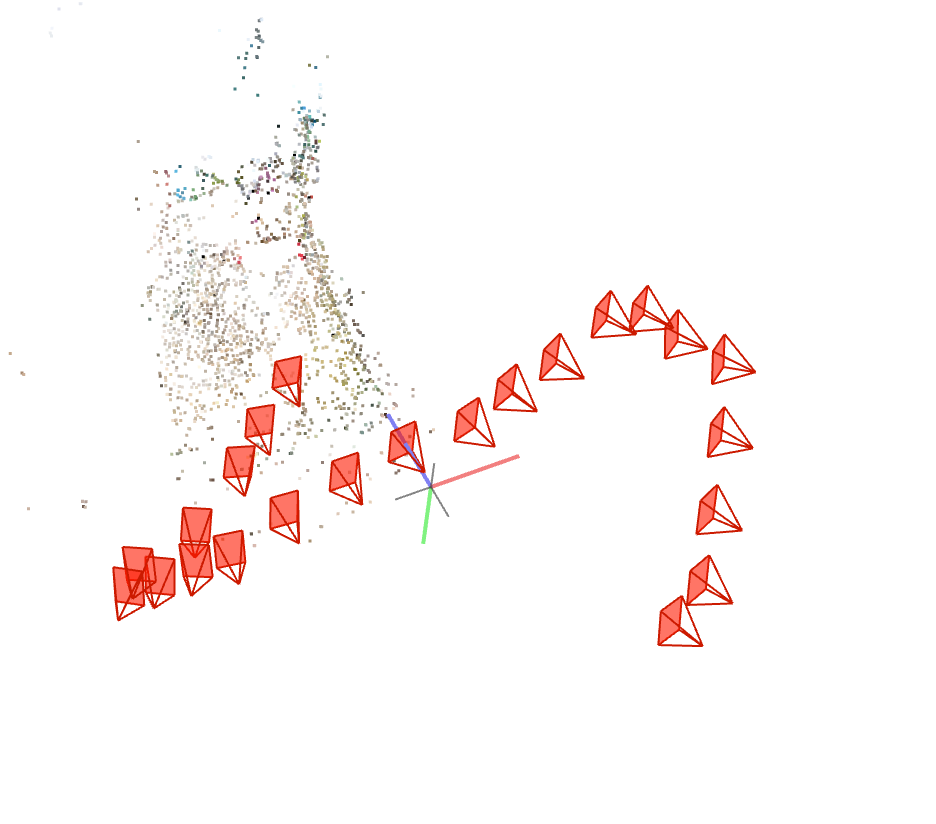